# <font color = seagreen>Project Goal</font>

I will be building a **recommender system** similar to those that we find in any digital content provider. I will attempt to predict user's preferences based upon past ratings.  The technique I used is called a **Model-Based Collaborative Filtering** where we build a machine learning model to predict user ratings of the unrated items based upon past ratings (rather than outside information).  

## <font color = seagreen>The Data</font>

I have used a subset of Amazon reviews data(scraping all reviews prior to 2014) for this basic recommender system. This dataset consists of User ID, ASIN and star ratings. There is data available on http://jmcauley.ucsd.edu/data/amazon/  which is restricted to k-core, where k means that each ASIN consists of atleast k-reviews and each user will have rated atleast k-books. I have chosen a **40-core** dataset for my recommender system.  

## <font color = seagreen>Deliverables/Learnings</font>

-  Providing my learning in this notebook as a comment beside the statements.
-  Using few methods/Attributes on the Dataframe 
-  About the data model


In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math as math

from sklearn.model_selection import train_test_split

#### <font color = goldenrod>Loading the data into dataframe </font>

In [2]:
data = pd.read_csv('Book_Ratings.csv', dtype = {'User': str, 'ASIN': str, 'Rating': np.int})  ## "dtype" here specifies the data type of the column
print "Sample Data"
print "-----------"
print data.sample(20)             ## Generates 20 random rows from the dataset

Sample Data
-----------
                 User        ASIN  Rating
35111  A1GUNBQDH7YE86  1469982994       5
41633  A3HY7DE45OAY0G  1476755590       4
24421  A1D427FYPTSWR0  0989492559       4
82602   AEBY5PBQM7G1R  149542118X       5
75430  A1T55654YUB2L1  1492884685       5
26503   A19UT0OPQCDR8  0991686004       3
26292   A19UT0OPQCDR8  0991426711       5
23141  A3T53I4UUNBKLK  0989416496       4
51573  A2KOR8DEDS4HZ3  1481060139       5
14414  A2ZU73E6RDADJV  0615910521       5
66763   AE4H1E8A90ZHT  1490471103       5
10553  A3GO2NJ0KTUOAF  0615741932       5
82406  A3D4Z4MKKR3LZD  149539090X       5
5824   A17Y1M3GQZ5OL0  0425266745       5
36822  A3GUHMXFZRA2NO  1476718202       5
20385   ALY4MQYVAEE4U  0989104400       5
50107  A320NYVVIZSZGY  148023365X       5
77722   ALRATUC4DP146  1493649779       4
51752   A9U38KC8SCFAE  1481100920       5
99176  A2LBU8ZARC0QHC  B00EA45DUO       4


####  <font color = goldenrod>Counting number of unique users and unique ASINs in the dataset </font>

In [3]:
uniqueUsers = data['User'].unique().tolist()
uniqueASINs = data['ASIN'].unique().tolist()
numUser = len(uniqueUsers)
numASIN = len(uniqueASINs)
print numUser
print numASIN


1490
1186


#### <font color = goldenrod>Split to train and test data </font>

In [4]:
train, test = train_test_split(data, random_state = 8675309, stratify = data['ASIN'])
num_train = train.shape[0]
num_test = test.shape[0]

print "Number of Users: {}".format(numUser)
print "Number of ASINs: {}".format(numASIN)

Number of Users: 1490
Number of ASINs: 1186


####  <font color = goldenrod> On the training dataset,I have done some exploratory data analysis while learning pandas library
    - The fraction of ASINs that have more that 32, 64, and 128 reviews respectively. 
    - The number of Users that have more than 32, 64, and 128 reviews respectively?</font>

In [5]:
unique_asic_and_freq = train.ASIN.value_counts()
morethan32 = unique_asic_and_freq[unique_asic_and_freq>32].size
print morethan32
morethan64 = unique_asic_and_freq[unique_asic_and_freq>64].size
print morethan64
morethan128 = unique_asic_and_freq[unique_asic_and_freq>128].size
print morethan128

1068
433
119


#### <font color = goldenrod> I have played with matplotlib to plot some graphs.</font> 
####    - How the average rating a user gives depends varies with each rating that user gives.
####    - How the average rating an ASIN receives varies with the number of ratings that ASIN receives.

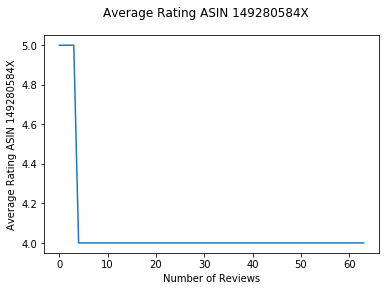

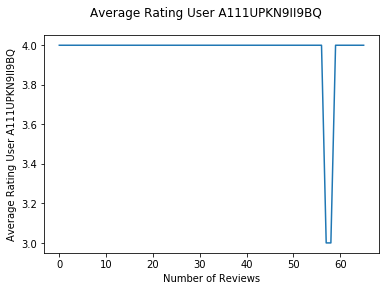

In [6]:
def plot_average_ratings(datatype = None, datavalue = None):
    ratings= train.loc[train[datatype] == datavalue].Rating.tolist()
    averages = []
    value = 0
    for i in range(len(ratings)):
        value += ratings[i]
        averages.append(value/(i+1))
    graph1 = plt.figure()
    graph1.suptitle('Average Rating {} {}'.format(datatype, datavalue))
    plt.plot(averages)
    plt.xlabel('Number of Reviews')
    plt.ylabel('Average Rating {} {}'.format(datatype, datavalue))
    
plot_average_ratings('ASIN', '149280584X')
plot_average_ratings('User', 'A111UPKN9II9BQ')

## <font color = seagreen>About the model</font>

For the model I used, I have constructed a score matrix $S = \left(s_{i,j}\right)$ which is a $n\times m$ matrix where
$$
s_{i,j} = \begin{cases}
r & \text{if the rating by user $i$ to ASIN $j$ was $r$ stars,}\\
0 & \text{otherwise,}
\end{cases}
$$
where $n$ is the number of users and $m$ is the number of ASINs.

As known before, our main goal is to find the unrated ratings of the ASINs. Therefore, we also need a matrix of which ASINs were rated. Let us consider that matrix to be $R = \left(r_{i,j}\right)$ where,
$$
r_{i,j} = \begin{cases}
1 & \text{if user $i$ rated ASIN $j$,}\\
0 & \text{otherwise.}
\end{cases}
$$

Finally, my goal is to construct a prediction matrix  $P = (p_{i,j})$ which fills in all the missing scores where $r_{i,j} = 0$ (i.e the ones which has value 0 in the matrix $\left(r_{i,j}\right)$ ). For this prediction matrix we need to assume that P is generated from some formula.

**Here is the idea I followed to generate P :**

To each ASIN $j$ we will associate $k$ features $(f_{\ell,j})_{\ell = 1}^k$, and to each user $i$ we will associate $k$ affinities $(a_{i,\ell})_{\ell=1}^k$.  These features can be thought of as simple descriptors of the book, like for instance amount of action or romance.  The affinities can be thought of as providing how much a person likes or dislikes a feature so perhaps $+1$ for action since they like action, and $-0.5$ for romance.

We will calculate, rating that a person will assign to a ASIN will be taken as a sum over all the features of their affinities for that feature times that ASIN's features. The matrix notation for this is **P = FA**.

Let **'F' denote the Feature matrix** of all the asins and the dimensions for 'F' will be a $j*k$ matrix, if there are  'j' asins and each asin has 'k' features.
Similarly, let **'A' denote the Affinity matrix** for all the users and dimensions for 'A' will be $k*i$ matrix, where there are  'k' affinites for each user and there are 'i' users.

In the concept of **Model based Collaborative filtering**, a *parameter* is a number that needs to be fixed/identified in order to specify a model completely. In my case, every affinity and every feature is a parameter and must be specified for our model to be able to make predictions. **Hence, the number of parameters involved are** $i*k + j*k$ 

And, now if we calculate P as $P = FA$, number of entries in 'P' matrix is $i*j$

The values of $i,j and k$ decides the relationship between number of parameters and number of entries in $P$
But in realworld problems $i,j >> k$, so number of entries are larger than parameters.

Now we will build the score matrix and the mask matrix from the data set.
                        
                        
                        




                            

In [7]:
S_train = train.pivot(index='User', columns='ASIN', values='Rating')
#print train
print S_train
R_train = ((S_train.notnull()).astype('int'))
print R_train
S_test = test.pivot(index='User', columns='ASIN', values='Rating')
R_test = ((S_test.notnull()).astype('int'))

ASIN                   0007442920  0062267159  0062267175  006226768X  \
User                                                                    
A01911642JTFI4ONWRUNF         NaN         NaN         NaN         NaN   
A06120993HKK17SIDKLPM         NaN         NaN         NaN         NaN   
A09693182VLGN7ZC626US         NaN         NaN         NaN         NaN   
A1098Z3D7ENJ2F                NaN         NaN         NaN         NaN   
A10A5HRIBOEYAR                NaN         NaN         NaN         NaN   
A10AIF1PLY52Y1                NaN         NaN         NaN         NaN   
A10C5RP21MQYT6                NaN         4.0         NaN         NaN   
A10DEXQ4RLDEWO                NaN         NaN         NaN         NaN   
A10DX94ATZQEFG                NaN         NaN         NaN         NaN   
A10G4B3KCHZ89S                5.0         5.0         NaN         NaN   
A10M573AXOM1BG                NaN         NaN         NaN         NaN   
A10PXQY535XY39                NaN         NaN      

We will now build out prediction matrixz $P$.
To get this we need to build affinity matrix $A$ and feature matrix $F$.
Since we are only learning the model based collabarative filter algorithm and trying it out on amazon data set, we will look for one feature in every book and every user affinity towards that one feature.

Lets pick the single feature as the average star rating a book received, and everyone has affinity of $+1$ for that feature. When I did the product of $P=AF$, it predicts every single user gives the same rating to the ASIN, and that rating is the average value.

Let's refer this as *baseline model*.
Now we will build F, A and P matrices and plot histogram of the prediction matrix.

([array([  3.,   6.,  20.,  43., 102., 174., 264., 306., 208.,  60.]),
  array([  3.,   6.,  20.,  43., 102., 174., 264., 306., 208.,  60.]),
  array([  3.,   6.,  20.,  43., 102., 174., 264., 306., 208.,  60.]),
  array([  3.,   6.,  20.,  43., 102., 174., 264., 306., 208.,  60.]),
  array([  3.,   6.,  20.,  43., 102., 174., 264., 306., 208.,  60.]),
  array([  3.,   6.,  20.,  43., 102., 174., 264., 306., 208.,  60.]),
  array([  3.,   6.,  20.,  43., 102., 174., 264., 306., 208.,  60.]),
  array([  3.,   6.,  20.,  43., 102., 174., 264., 306., 208.,  60.]),
  array([  3.,   6.,  20.,  43., 102., 174., 264., 306., 208.,  60.]),
  array([  3.,   6.,  20.,  43., 102., 174., 264., 306., 208.,  60.]),
  array([  3.,   6.,  20.,  43., 102., 174., 264., 306., 208.,  60.]),
  array([  3.,   6.,  20.,  43., 102., 174., 264., 306., 208.,  60.]),
  array([  3.,   6.,  20.,  43., 102., 174., 264., 306., 208.,  60.]),
  array([  3.,   6.,  20.,  43., 102., 174., 264., 306., 208.,  60.]),
  arra

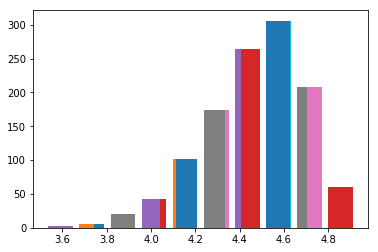

In [8]:
F=S_train.mean(axis=0)
A=S_train.mean(axis=1)
A[A>=0] = 1
dff = pd.DataFrame(F)
dfa = pd.DataFrame(A)
avg_asin_scores = dfa.dot(dff.T)

plt.hist(avg_asin_scores)

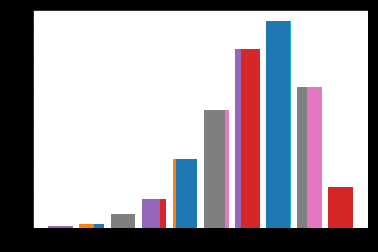

The above model is deterministic, i.e the predictions are given by the product $P=AF$.In the real world , we will have that $S$ looks like $P=AF$ plus some independent random noise, where that random noise is designed to capture all the inaccuracies in our model.
The inaccuracies can be
- There are many features that determine how much a person will like a book.
- There can be random fluctuation in the rating given depending on things unrelated to the book at all.

I have calculated this by saying that $S \sim P + \mathcal{N}(0,\sigma^2)$ where we choose to model our noise as independent additive Gaussian noise. It can be read as, every rating we observed $s_{i,j}$ is distributed as a our prediction $p_{i,j}$ plus independent mean zero Gaussian noise for every observed rating.  Since adding a constant to a Gaussian just shifts the mean, we can also say that $s_{i,j}\sim\mathcal{N}(p_{i,j},\sigma^2)$.  The scale of the noise, $\sigma^2$, is now an additional parameter of our model.

The probability density of Gaussian $\mathcal{N}(\mu,\sigma^2)$ is 
$$
\frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{(x-\mu)^2}{2\sigma^2}}.
$$

For one observed rating maximum likelihood is equal to 
$$ \left(\frac{1}{\sqrt{2\pi\sigma^2}}\right) e^{-\frac{1}{2\sigma^2}(s_{i,j} - p_{i,j})^2}. $$

since, the probabilities of independent events multiply and is also true for probability densities of random variables. So when I have two Gaussians $X \sim \mathcal{N}(0,1)$ $Y \sim \mathcal{N}(1,2)$, and  calculate the associated density for observing $X = 1$ and $Y = 2$, this is
$$
\frac{1}{\sqrt{2\pi}}e^{-\frac{(1-0)^2}{2}}\times\frac{1}{\sqrt{8\pi}}e^{-\frac{(2-1)^2}{8}} = \frac{1}{4\pi}e^{-\frac{5}{8}}
$$

Since all the ratings are independent, maximum likelihood for K observed ratings is multplying the likelihood for each observed rating which is, 
               > $$ \left(\frac{1}{\sqrt{2\pi\sigma^2}}\right)^K e^{-\frac{1}{2\sigma^2}\sum_{i,j \text{ observed}}(s_{i,j} - p_{i,j})^2}. $$


With this noise model, I have calculted the maximum likelihood that the calculated predictions are just as close the values from the data set.

Now, I need to figure out a way to maximize the above function.

Because $e^{-x}$ is a decreasing function, maximizing the above function  is the same thing as minimizing the sum in the exponential.

Therefore,  maximizing the probability is the same as minimizing
$$\sum_{i,j \text{ observed}}(s_{i,j} - p_{i,j})^2$$
which is nothing but the sum of squared errors. 

This is often called as the mean squared error, which is nothing but the average squared error we make.

$$\frac{1}{K}\sum_{i,j \text{ observed}}(s_{i,j} - p_{i,j})^2.$$ I will take Root Mean Square (RMS) error which tells how far our predictions are off on average and is obtained by taking the square root of the value above:
$$
RMS = \sqrt{\frac{1}{K}\sum_{i,j \text{ observed}}(s_{i,j} - p_{i,j})^2}.
$$
The above expression can also be written as 
$$
RMS = \frac{1}{\sqrt{K}}\|R\circ(S-P)\|_2
$$



Now, To compute the RMS error given predictions $P$ and observations encoded as $R$ and $S$.I have implemented a function that computes the RMS error, given predictions $P$ and observations encoded as $R$ and $S$. I have calculated RMS value for
- Prediction matrix and train data
- Prediction matrix and test data

In [9]:
#print S_test

#print avg_asin_scores
#print R_test
#0007442920  0062267159  0062267175  006226768X
#ASIN                   0007442920  0062267159  0062267175  006226768X  \
#User                                                                    
#A01911642JTFI4ONWRUNF           0           0           0           0 

#0.162542854091
import math
def rms(s_val = None, r_val = None, avg = None):
    s_val = s_val.fillna(0)
    norm_val =  np.linalg.norm( r_val.multiply(s_val - avg))
    rms = norm_val/(math.sqrt(numUser * numASIN))
    return rms
    
print rms(S_train, R_train, avg_asin_scores)
print rms(S_test, R_test, avg_asin_scores)

0.16254285409094657
0.09461531080022732


Now we need to minimize the root mean square error, so that train data and the prediction matrix are as close as possible.

We will do so by using gradient descent algorithm.

Lets assume that our RMS function looks like that
$$
L(p) = \frac{1}{K}\sum_{i,j \text{ observed}}(s_{i,j} - p_{i,j})^2 = \frac{1}{1}(4-p)^2 = (4-p)^2
$$

It is easy to say that the best prediction is $p=4$ in this case
but lets use gradient descent to figure that out.

##### For the above example, $L(p) = (4-p)^2$, we will implement gradient descent for $100$ steps of optimization starting at $p = 0$ with four different choices of learning rate: $0.01,0.1,0.99,1.0,1.001$.  we will also plot how the value of $L(p)$ changes with the number of steps of gradient descent.

In [1]:
def sample_gradient_descent(p_init=None, lrate =None):
    p_vals=[]
    l_vals=[]
    x = p_init
    for i in range(100):
        p_vals.append(x)
        l_vals.append((4-x)**2)
        x = x + (2*lrate*(4-x))
    plt.plot(l_vals)
    plt.ylabel('Loss Function')
    plt.xlabel('Number of P values')

sample_gradient_descent(8, 0.01)
sample_gradient_descent(8, 0.1)
sample_gradient_descent(8, 0.99)
sample_gradient_descent(8, 1.0)
sample_gradient_descent(8, 1.001)

NameError: global name 'plt' is not defined